In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw, ImageOps

np.random.seed(12)

In [2]:
def read_image(path):
    return Image.fromarray((plt.imread(path)*255).astype(np.uint8))

## Explore images generation

In [4]:
path_to_backgrounds = '../DOTA/images_p1/'
background = read_image(path_to_backgrounds + 'P0076.png')
background.size

(719, 635)

In [5]:
tank = read_image('images/objects/tank-t72b3.png')
tank.size

(319, 133)

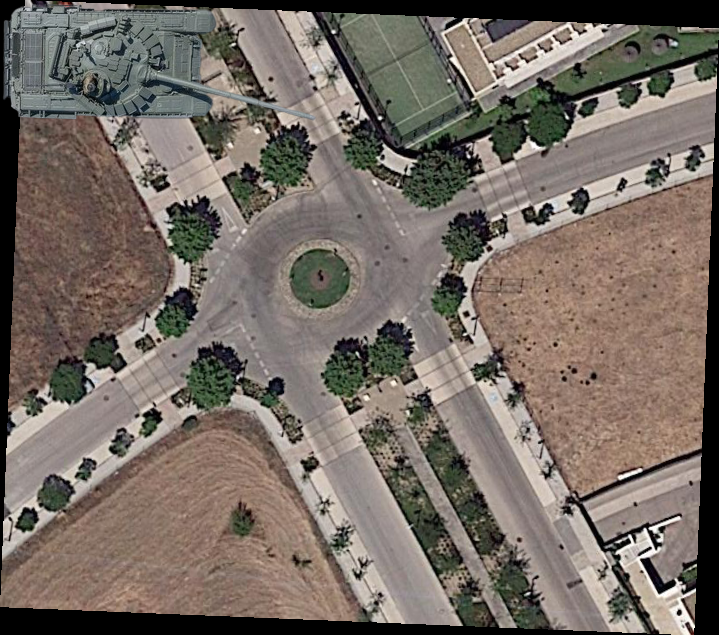

In [6]:
sample = background.copy()
sample.paste(tank, (0,0), tank)
sample

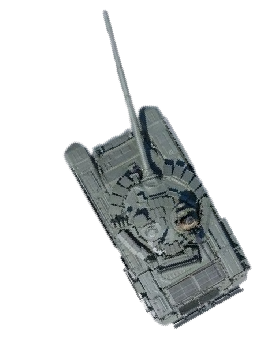

In [7]:
tank_r = tank.rotate(120, expand=True)
tank_r

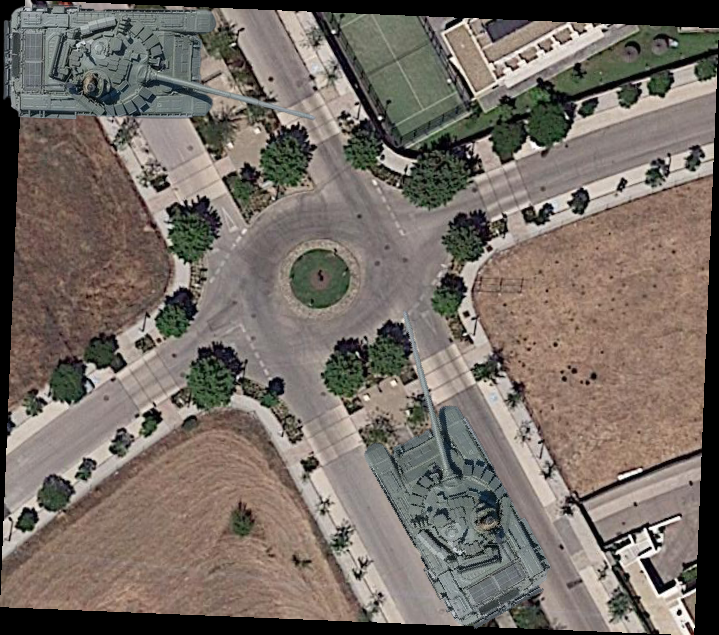

In [8]:
sample.paste(tank_r, (300,300), tank_r)
sample

In [9]:
def crop(img, new_width=608, new_height=608):
    width, height = img.size

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    return img.crop((left, top, right, bottom))

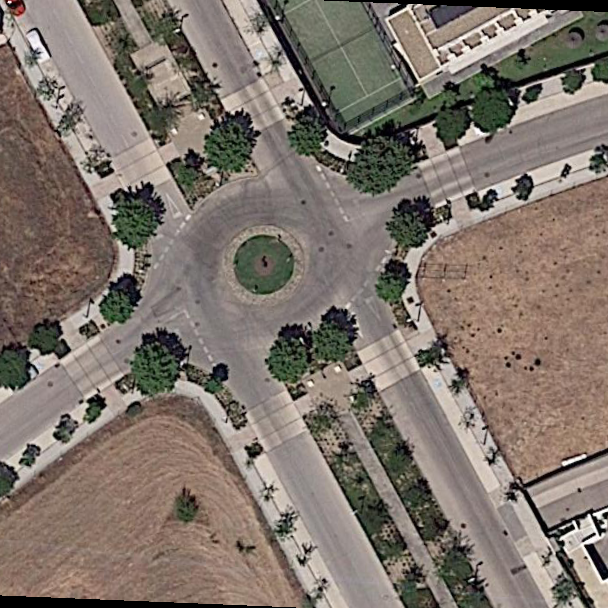

In [10]:
background = crop(background)
background

In [11]:
def resize(image, target_width):
    target_height = int(image.size[1]*target_width/image.size[0])

    return image.resize((target_width,target_height))

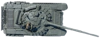

In [12]:
resize(tank, 100)

In [13]:
from os import listdir
path_to_objects = 'images/objects/'
v_list = listdir(path_to_objects)
v_list

['ifv-bmp-2m.png',
 'ifv-bmp-3.png',
 'ifv-btr-82a.png',
 'ifv-deryvatsia-pvo.png',
 'ifv-kurganets-25.png',
 'mlrs-9k58-smerch.png',
 'tank-t72b3.png']

In [14]:
classes = ['ifv', 'mlrs', 'tank']

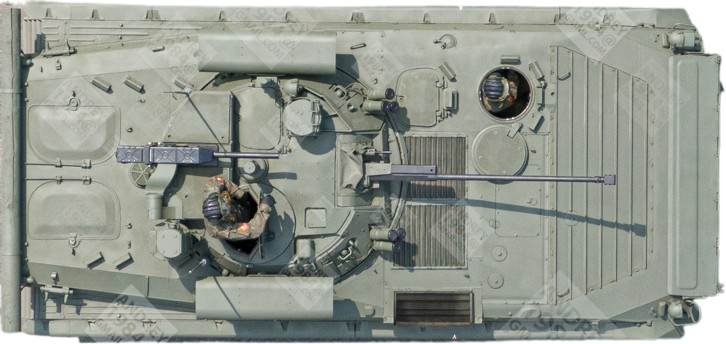

In [15]:
vehicles = [read_image(path_to_objects + v) for v in v_list]
vehicles[0]

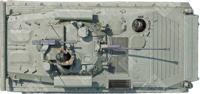

In [16]:
resize(vehicles[0], 200)

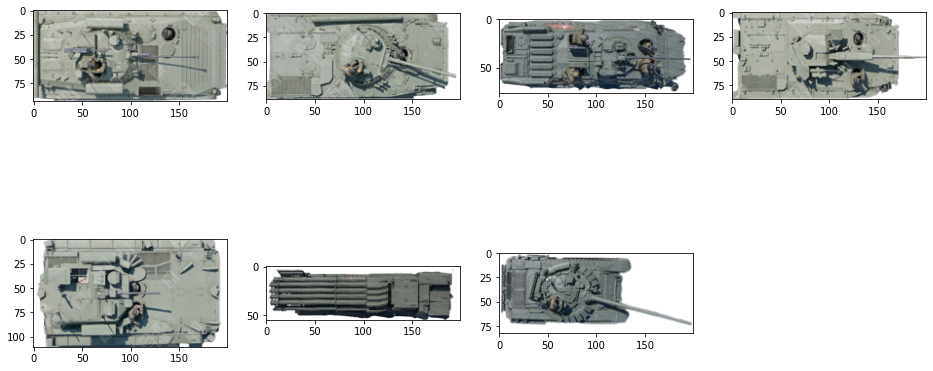

In [17]:
plt.figure(figsize=(16, 8))

for i in range(0, 7):
    plt.subplot(2, 4, i + 1)
    plt.imshow(resize(vehicles[i], 200))

plt.show()

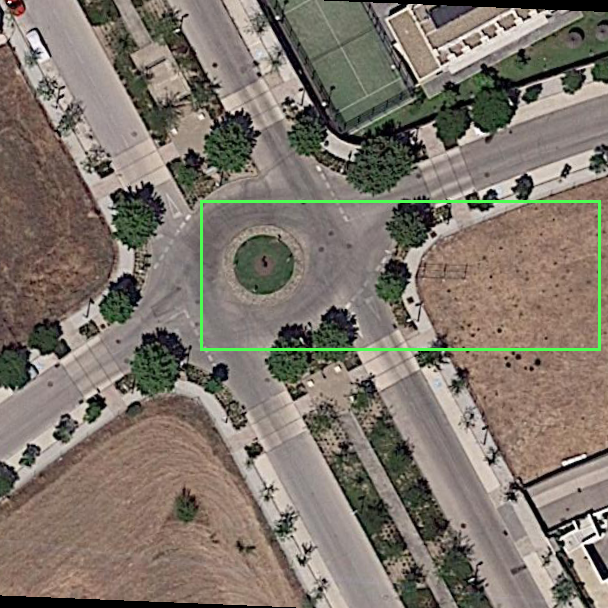

In [18]:
image = background.copy()
draw = ImageDraw.Draw(image)
draw.rectangle((200, 200, 600, 350), outline='#4CFF52', width=3)
image

In [19]:
#TODO preserve real-world ratio between objects

objects = [(resize(v, 100), v_list[i].split('-')[0]) for i, v in enumerate(vehicles)]
objects

[(<PIL.Image.Image image mode=RGBA size=100x47 at 0x2034EB0CD90>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=100x44 at 0x2034E831F70>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=100x38 at 0x2034E831E20>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=100x45 at 0x2034E831370>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=100x55 at 0x2034E831CA0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=100x27 at 0x2034E8313A0>, 'mlrs'),
 (<PIL.Image.Image image mode=RGBA size=100x41 at 0x2034E831D00>, 'tank')]

In [20]:
def put_objects(background, n_min=1, n_max=10, objects=objects):
    base = background.copy()
    n = np.random.randint(n_min, n_max+1)
    
    bboxes = []
    for i in range(n):
        obj, obj_type = objects[np.random.randint(len(objects))]
        int_type = classes.index(obj_type)
        
        obj = obj.rotate(np.random.randint(360), expand=True)
        x, y = np.random.randint(background.size[0]) - obj.size[0]//2, np.random.randint(background.size[1]) - obj.size[1]//2
        
        bboxes.append((int_type, x, y, x + obj.size[0], y + obj.size[1]))
        
        base.paste(obj, (x, y), obj)
    
    return base, bboxes 
        

[(1, 222, 382, 296, 483), (2, 424, 367, 522, 470), (0, 30, 329, 118, 440), (1, 178, 217, 230, 322), (0, 271, 49, 311, 151), (0, 64, 407, 174, 488), (0, 415, 161, 525, 256)]


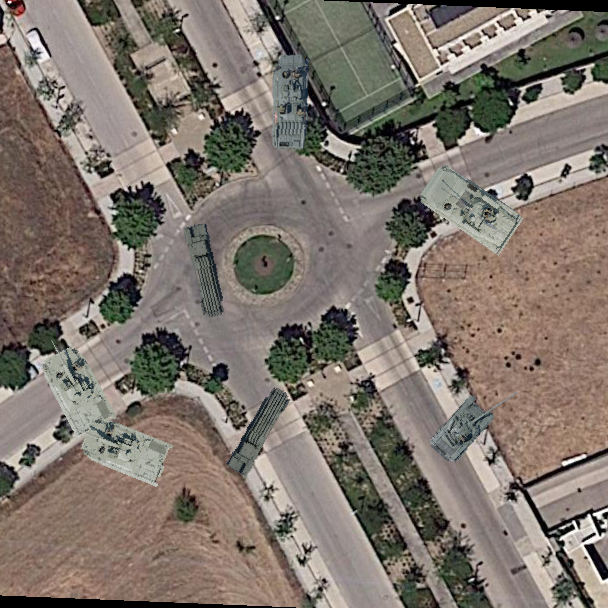

In [21]:
base, bboxes = put_objects(background)
print(bboxes)
base

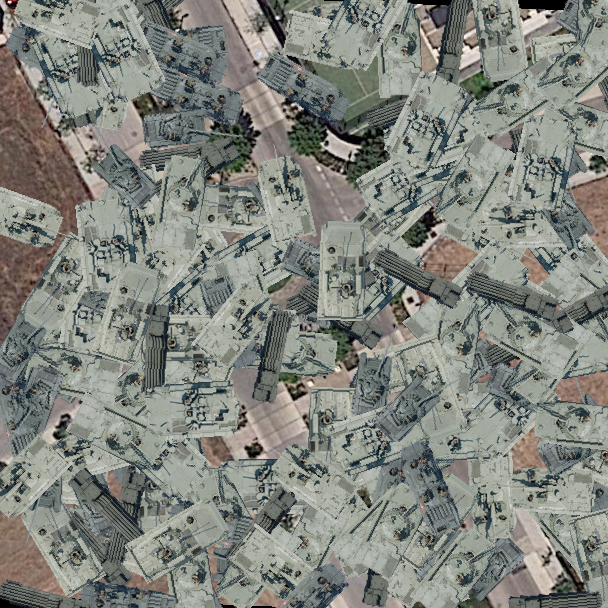

In [22]:
put_objects(background, 100, 200)[0]

In [82]:
def plot_boxes(image, boxes, outline='#4CFF52', width=3):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    
    for b in boxes:
        print(b[1:])
        draw.rectangle(b[1:], outline=outline, width=width)
        
    return image

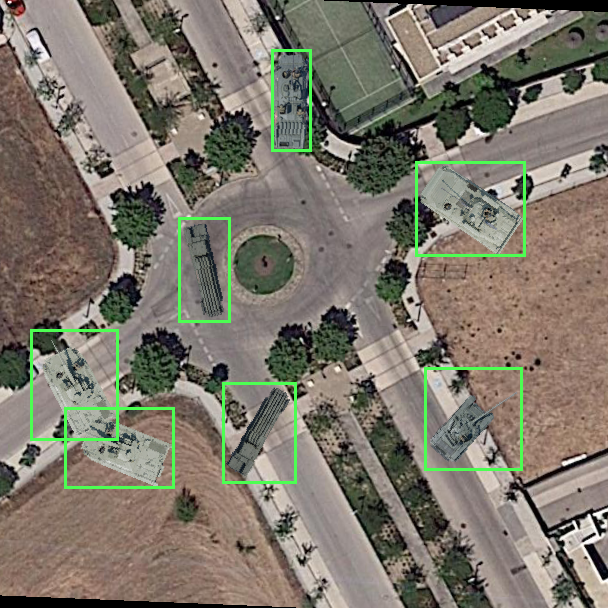

In [24]:
plot_boxes(base, bboxes)

## Generate dataset in YOLO format

In [25]:
def transform_boxes(bboxes, denominator=608):
    bboxes = np.array(bboxes)
    result = np.zeros((bboxes.shape[0], 5))
    
    labels = bboxes[:,0]
    
    # centers
    x_c = (bboxes[:,1] + bboxes[:,3])/2
    y_c = (bboxes[:,2] + bboxes[:,4])/2

    width = bboxes[:,3] - bboxes[:,1]
    height = bboxes[:,4] - bboxes[:,2]
    
    result[:,1] = x_c
    result[:,2] = y_c
    result[:,3] = width
    result[:,4] = height
    
    result /= denominator
    
    result[:,0] = labels

    return result

In [26]:
bboxes

[(1, 222, 382, 296, 483),
 (2, 424, 367, 522, 470),
 (0, 30, 329, 118, 440),
 (1, 178, 217, 230, 322),
 (0, 271, 49, 311, 151),
 (0, 64, 407, 174, 488),
 (0, 415, 161, 525, 256)]

In [27]:
transform_boxes(bboxes)

array([[1.        , 0.42598684, 0.71134868, 0.12171053, 0.16611842],
       [2.        , 0.77796053, 0.68832237, 0.16118421, 0.16940789],
       [0.        , 0.12171053, 0.63240132, 0.14473684, 0.18256579],
       [1.        , 0.33552632, 0.44325658, 0.08552632, 0.17269737],
       [0.        , 0.47861842, 0.16447368, 0.06578947, 0.16776316],
       [0.        , 0.19572368, 0.73601974, 0.18092105, 0.13322368],
       [0.        , 0.77302632, 0.34292763, 0.18092105, 0.15625   ]])

In [28]:
def generate_data(input_dir, output_dir, take_from=0, take_to=-1):
    output_imgs = output_dir + 'images/'
    output_lbls = output_dir + 'labels/'
    
    background_pathes = listdir(input_dir)
    
    for path in background_pathes[take_from:take_to]:
        img = crop(read_image(input_dir + path), 608, 608)
        base, boxes = put_objects(img, 1, 5)

        base.save(output_imgs + path)

        np.savetxt(output_lbls + path[:-4] + '.txt', transform_boxes(boxes))

In [29]:
train_input_dir = '../DOTA/images_p1/'
train_output_dir = '../generated/train/'

val_input_dir = '../DOTA/images_p2/images/'
val_output_dir = '../generated/val/'

test_input_dir = '../DOTA/images_p3/selected/'
test_output_dir = '../generated/test/'

In [30]:
generate_data(train_input_dir, train_output_dir)

In [31]:
generate_data(val_input_dir, val_output_dir, take_from=-100)

In [32]:
generate_data(test_input_dir, test_output_dir)

## Read generated data

In [33]:
img_name = 'P0011'

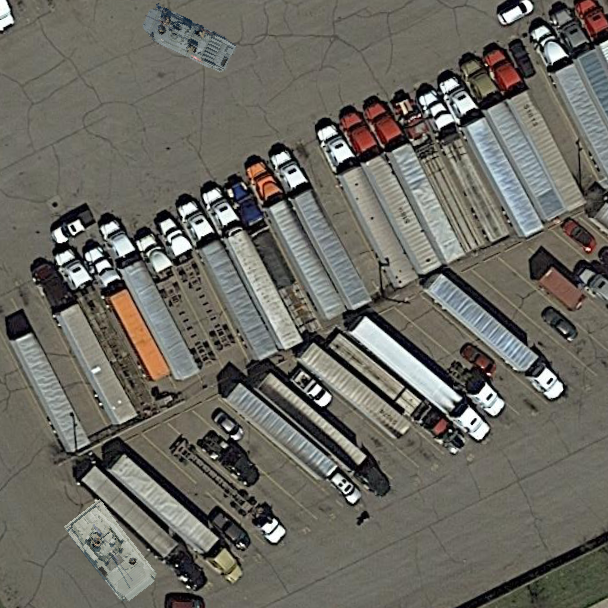

In [42]:
test_img = read_image(train_output_dir + 'images/' + img_name + '.png')
test_img

In [55]:
test_boxes = np.loadtxt(train_output_dir + 'labels/' + img_name + '.txt')
test_boxes

array([[0.        , 0.30756579, 0.06085526, 0.17763158, 0.12828947],
       [0.        , 0.18421053, 0.90871711, 0.16447368, 0.17927632]])

In [94]:
a = test_boxes * 608
a

array([[  0. , 187. ,  37. , 108. ,  78. ],
       [  0. , 112. , 552.5, 100. , 109. ]])

In [95]:
w_delta = a[:,3] / 2
h_delta = a[:,4] / 2

In [96]:
w_delta

array([54., 50.])

In [97]:
a[:,1]

array([187., 112.])

In [98]:
a[:,1] -= w_delta
a[:,2] -= h_delta
a[:,3] += w_delta
a[:,4] += h_delta
a

array([[  0. , 133. ,  -2. , 162. , 117. ],
       [  0. ,  62. , 498. , 150. , 163.5]])

[187.0, 37.0, 187.0, 37.0]
[133.0, -2.0, 241.0, 76.0]
[148.0, -17.0, 226.0, 91.0]


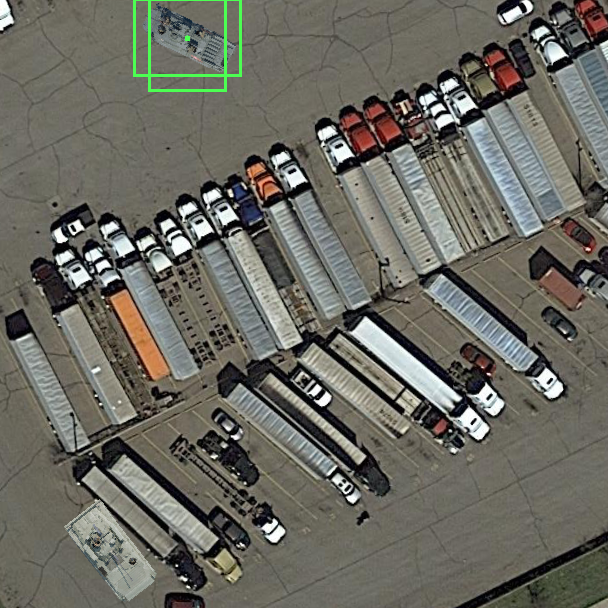

In [104]:
plot_boxes(test_img, [[0, 187.,  37., 187.,  37.],
                      [0, 187. - 108/2, 37. - 78/2,187. + 108/2, 37. + 78/2],
                      [0, 187. - 78/2, 37. - 108/2,187. + 78/2, 37. + 108/2]])